# Import

In [3]:
table = pd.read_csv(
    base_dir + '/example_table.csv', 
    dtype=str, sep='\t'
)
table['Threatened Species'] = 'None mentioned'
table['Map'] = False
species = pd.read_csv('threatened_species_202010.csv')

Extract "Threatened Species" and "Map?" column.

In [3]:
example_folders = [x[0].replace('/','') + '_' + x[1].replace('/','') for x in table[['Reference Number', 'Date of notice']].values]

In [4]:
# Check for scientific names 
# Loop through pdf files. Convert pdf to text. Search for scientific names.
folders = os.listdir("./files")

In [5]:
folders_revised = []
for folder in folders:
    for example_folder in example_folders:
        if example_folder in folder:
            folders_revised.append(folder)

In [6]:
folders_revised = list(set(folders_revised))
len(folders_revised)

93

In [7]:
folders=folders_revised

In [66]:
# Loop through folders
for folder in folders_revised:
    print(folder)
    try:
        fn = folder.split('_')[0] + '_' + folder.split('_')[1] + '_combined.pdf'
        pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
        pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
    except:
        try:
            fn = folder + '_combined.pdf'
            pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
            pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
        except:
            continue

    try:
        pages = [
            pdf_reader.getPage(i).extractText().replace('\n', '') 
            for i in range(pdf_reader.numPages)
        ]
    except:
        continue
    text = ''.join(pages)
    
    text_lower = text.lower()
    sci_name = species['Scientific Name'].apply(lambda x: x.lower()).values
    comm_name = species['Common Name'].loc[
        np.logical_and(
            species['Common Name'] != 'a shrub', species['Common Name'] != '-'
        )
    ].apply(lambda x: x.lower()).values

    [sci_name_exist, comm_name_exist] = [
        [
            species['Common Name'].values[i] + ', ' 
            + species['Scientific Name'].values[i] + ' (' 
            +  species['Threatened status'].values[i] + ')' 
            for i in range(len(name)) if name[i] in text.lower()
        ]
        for name in [sci_name, comm_name]
    ]
    
    if 'coordinates' in text.lower() or 'latitude' in text.lower() or 'longitude' in text.lower() or ' map ' in text.lower():
        coordinates_mentioned = True
    else:
        coordinates_mentioned = False

    species_mentioned = sorted(
        list(set(sci_name_exist).union(set(comm_name_exist)))
    )
    species_mentioned = ', '.join(species_mentioned)
    
#     Extract text coordinates
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)
#     points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
#     points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

    id_nums = folder.split('_')
    date = id_nums[1][:2] + '/' + id_nums[1][2:4] + '/' + id_nums[1][4:]
    ref_num = id_nums[0][:4] + '/' + id_nums[0][4:]
    table['Threatened Species'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = species_mentioned
    table['Map'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = coordinates_mentioned

NameError: name 'folders_revised' is not defined

In [13]:
table.to_csv('example_revised_table.csv', index=False, header=True)

Extract KML from text.

In [5]:
import fitz

In [6]:
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)

In [8]:
points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

In [9]:
def convert_to_decimal(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(':',' ')
    new = new.split()
    new_dir = new.pop()
    return (abs(float(new[0]))+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]

In [10]:
points_lat = [convert_to_decimal(i) for i in points_lat]
points_lon = [convert_to_decimal(i) for i in points_lon]

In [11]:
len(points_lat)
# len(points_lon)

43

In [21]:
kml_coords = [(points_lon[i], points_lat[i]) for i in range(len(points_lat))]

In [25]:
import simplekml

trans_green_style = simplekml.Style()
trans_green_style.linestyle.width = 1.5
trans_green_style.polystyle.color = '7d00ff00'
trans_green_style.name = 'trans_green_style'

kml = simplekml.Kml()
kml.document.name = "Referral Name Text Extract"
pol1 = kml.newpolygon(name = "Referral Area", outerboundaryis=kml_coords)
pol1.style.linestyle.width = 1.5
pol1.style = trans_green_style

In [43]:
kml.save('simple_kml_test.kml')

In [18]:
direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
test = points_lat[0]

# Scrape Maps

In [50]:
try:
    remaining_pages = np.genfromtxt(
        base_dir + sub_dir + '/remaining_pages.csv'
    ).astype(int).tolist()
except:
    remaining_pages = copy.deepcopy(saved_pages)

## Scrape SVG

In [1]:
import menu
import fitz
import tkinter as tk
import subprocess

In [2]:
%load_ext autoreload
%autoreload 2
%pdb

Automatic pdb calling has been turned ON


In [3]:
file = 'C:/Users/eshor/Documents/ACF_consulting/files_test/20218905_24032021_invitation_for_public_comment_on_referral/20218905_24032021_invitation_for_public_comment_on_referral_combined.pdf'

pdf_file = fitz.open(file)
page = pdf_file[63]

> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(69)scrape_bmp()
     67     import pdb; pdb.set_trace()
     68 
---> 69     cmd = 'inkscape {} --export-filename={} '
     70     cmd += '--export-background=FFFFFFFF --export-area=0:0:{}:{}'
     71     cmd = cmd.format(

ipdb> c
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(91)scrape_bmp()
     89     import pdb; pdb.set_trace()
     90 
---> 91     sigma_min = 1
     92     sigma_max = 2
     93     features_func = partial(

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(92)scrape_bmp()
     90 
     91     sigma_min = 1
---> 92     sigma_max = 2
     93     features_func = partial(
     94         feature.multiscale_basic_features, intensity=True, edges=False,

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(93)scrape_bmp()
     91     sigma_min = 1
     92     sigma_max = 2
---> 93     features_func = partial(
     94         feature.multiscale_basic_features, intensity=True, edges=

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(98)scrape_bmp()
     96         multichannel=True)
     97     features = features_func(im2)
---> 98     clf = RandomForestClassifier(
     99         n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
    100     clf = future.fit_segmenter(training_labels, features, clf)

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(100)scrape_bmp()
     98     clf = RandomForestClassifier(
     99         n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
--> 100     clf = future.fit_segmenter(training_labels, features, clf)
    101     result = future.predict_segmenter(features, clf)
    102 

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(101)scrape_bmp()
     99         n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)
    100     clf = future.fit_segmenter(training_labels, features, clf)
--> 101     result = future.predict_segmenter(features, clf)
    102 
    103     fi

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(109)scrape_bmp()
    107     ax[0].set_title('Image, mask and segmentation boundaries')
    108 
--> 109     poly_box = np.zeros(im2.shape[:2])
    110     poly_box[pb_tl[1]:pb_br[1], pb_tl[0]:pb_br[0]] = 1
    111     poly_box = poly_box.astype(bool)

ipdb> n
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(110)scrape_bmp()
    108 
    109     poly_box = np.zeros(im2.shape[:2])
--> 110     poly_box[pb_tl[1]:pb_br[1], pb_tl[0]:pb_br[0]] = 1
    111     poly_box = poly_box.astype(bool)
    112     poly_box = np.logical_not(poly_box)

ipdb> c
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(152)scrape_bmp()
    150     import pdb; pdb.set_trace()
    151 
--> 152     styles = []
    153     for i in range(len(inds)):
    154         sty = simplekml.Style()

ipdb> c
> c:\users\eshor\documents\acf_consulting\scrape_bmp.py(211)scrape_bmp()
    209     import pdb; pdb.set_trace()
    210 
--> 211     if os.name ==

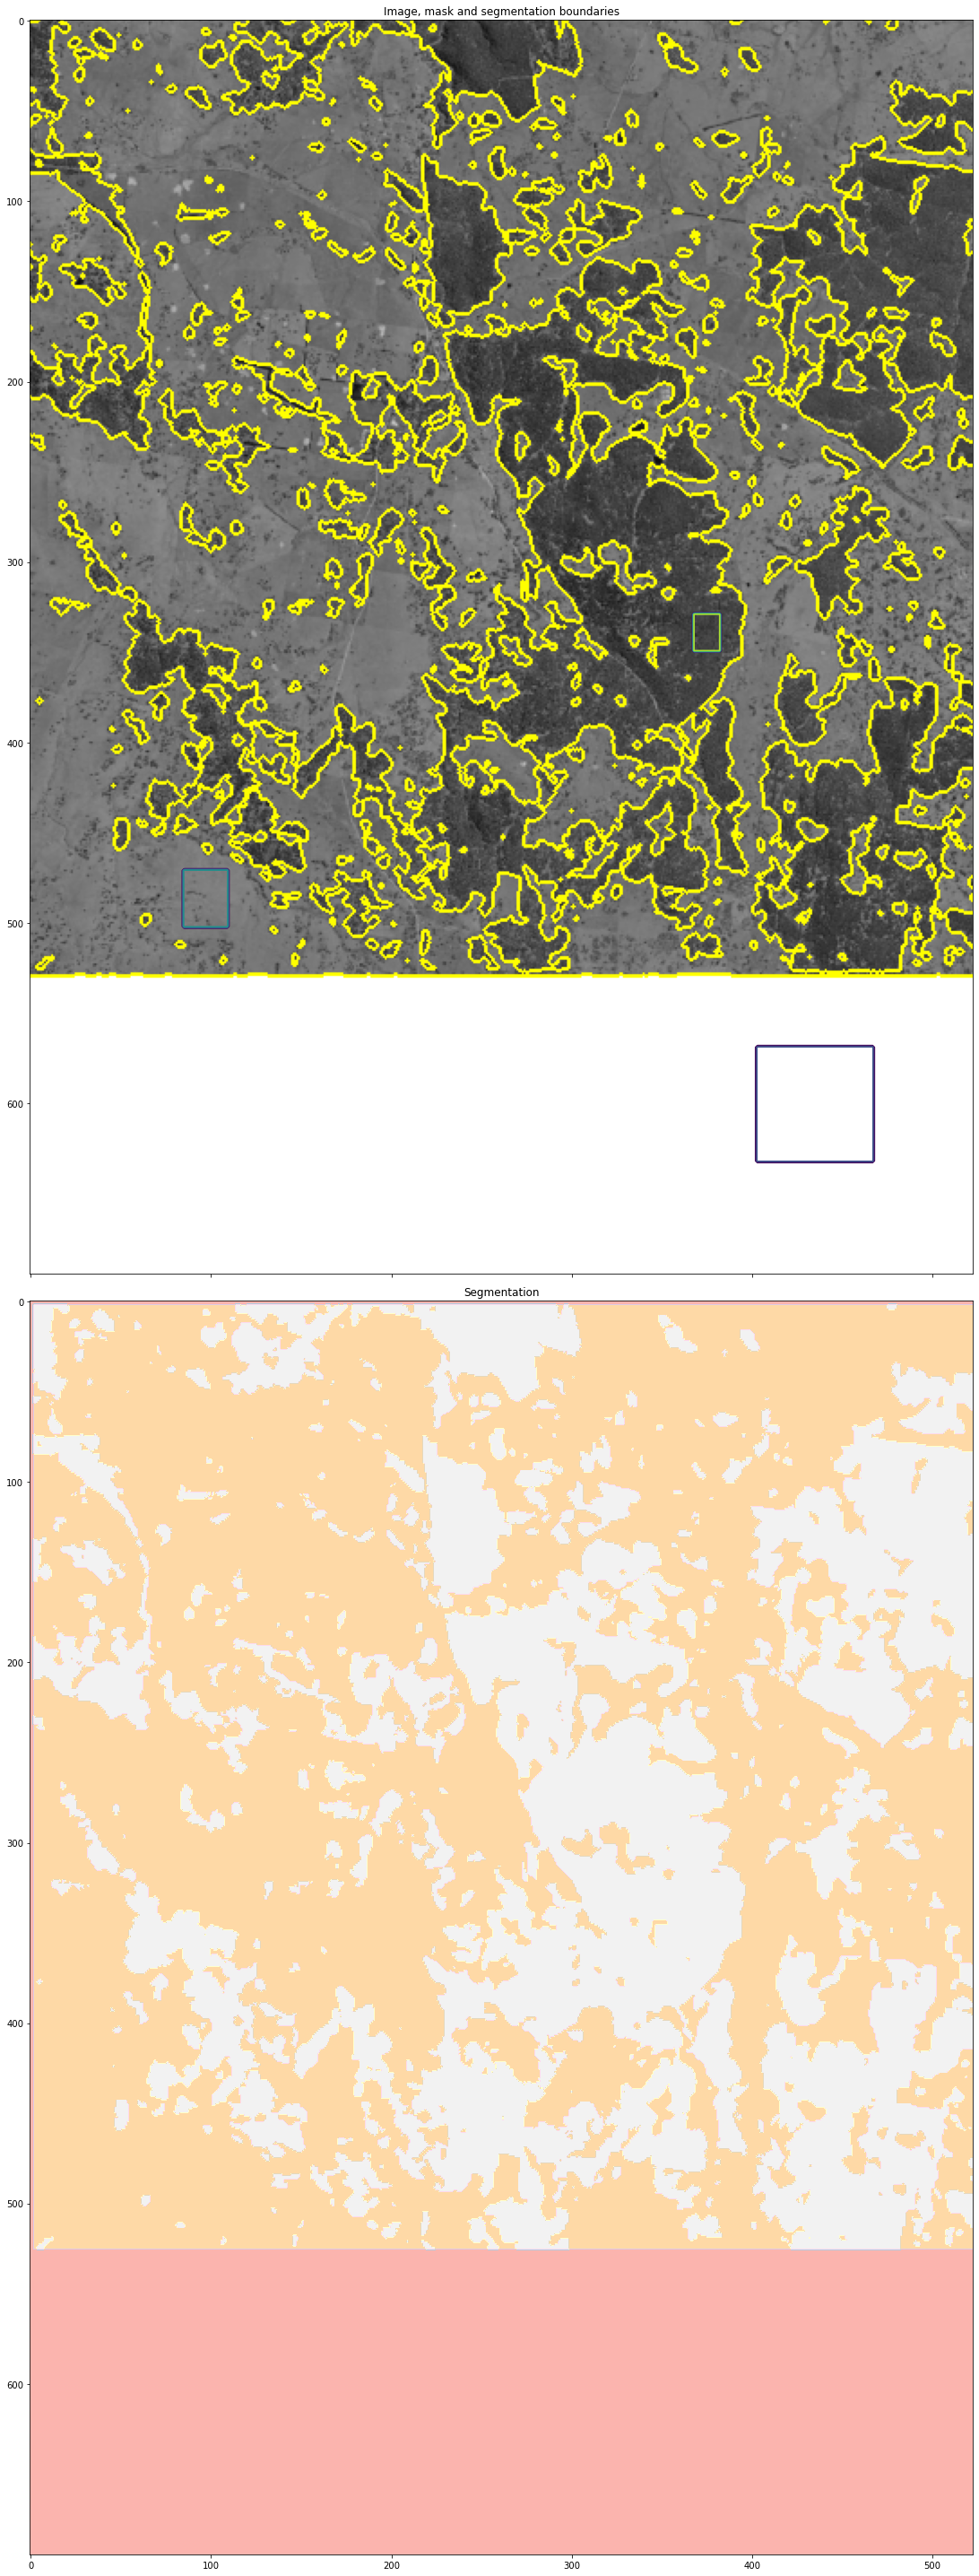

In [10]:
root = tk.Tk()
root.geometry('640x480')
# app = menu.Menu(
#     root, file, page_num=page_num, map_page_num=map_page_num, 
#     leg_names=leg_names, im1=im1,
#     im_leg=im_leg, pb_tl=pb_tl, pb_br=pb_br, LON=LON, LAT=LAT)
root.lift()
app = menu.Menu(
    root, filename=file, base_dir='C:/Users/eshor/Documents/ACF_consulting', page_num=page_num, map_page_num=map_page_num, 
    leg_names=leg_names, im1=im1,
    im_leg=im_leg, pb_tl=pb_tl, pb_br=pb_br, LON=LON, LAT=LAT)
# app = menu.Menu(
#     root, base_dir='C:/Users/eshor/Documents/ACF_consulting', filename=file,
#     search_terms=[], page_num=page_num, map_page_num=map_page_num, im1=im1, 
#     LON=LON, LAT=LAT)
# app = menu.Menu(
#     root, base_dir='C:/Users/eshor/Documents/ACF_consulting', filename=file,
#     search_terms=[], page_num=73)
root.mainloop()

In [5]:
page_num = app.page_num
map_page_num = app.map_page_num
leg_names = app.leg_names
im_leg = app.im_leg
pb_tl = app.pb_tl
pb_br = app.pb_br
LON = app.LON
LAT = app.LAT
im1 = app.im1